In [1]:
#!kaggle competitions download -c nlp-getting-started

In [1]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt

import emoji

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, SimpleRNN, Flatten, Conv1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import keras.backend as K 
from keras.callbacks import EarlyStopping

from keras.models import load_model


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer  
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *





Using TensorFlow backend.


In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/nlp-getting-started/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/nlp-getting-started/test.csv")


In [3]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [5]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [6]:
train.shape, test.shape, df.shape

((7613, 5), (3263, 4), (10876, 5))

In [7]:
df.tail()

,id,keyword,location,text,target
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10875,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [8]:
not_disaster = df.loc[df.target==0]
disaster = df.loc[df.target==1]

# EDA

In [9]:
for i in range(0, 10):
    print(i ,". ", disaster.text[i], "target: ",disaster.target[i] ) 

0 .  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all target:  1.0
1 .  Forest fire near La Ronge Sask. Canada target:  1.0
2 .  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected target:  1.0
3 .  13,000 people receive #wildfires evacuation orders in California  target:  1.0
4 .  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  target:  1.0
5 .  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires target:  1.0
6 .  #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas target:  1.0
7 .  I'm on top of the hill and I can see a fire in the woods... target:  1.0
8 .  There's an emergency evacuation happening now in the building across the street target:  1.0
9 .  I'm afraid that the tornado is coming to our area... target:  1.0


In [10]:
disaster.loc[pd.notnull(disaster.keyword)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


In [11]:
disaster.loc[pd.notnull(disaster.location)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


# Feature engineering

In [12]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [13]:
df['url']= df['text'].apply(lambda x:find_url(x))
df.loc[pd.notnull(df.url)]

,id,keyword,location,text,target,url
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0,http://t.co/lHYXEOHY6C
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0.0,http://t.co/YAo1e0xngw
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0,http://t.co/2nndBGwyEi
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0,http://t.co/qqsmshaJ3N
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0,http://t.co/3ImaomknnA
...,...,...,...,...,...,...
10865,10836,NaN,NaN,#Ebola #EbolaOutbreak Ebola Virus: Birmingham ...,NaN,http://t.co/tjpYlU9fOX
10866,10838,NaN,NaN,Malaysian PM confirms debris is from missing f...,NaN,http://t.co/pfAvW5QyqE
10868,10856,NaN,NaN,See the 16yr old PKK suicide bomber who detona...,NaN,http://t.co/hKuT5mSdtP
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,http://t.co/UtbXLcBIuY


In [14]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

extract_emojis("😘😳😍test")

'😘😳😍'

In [15]:
df['emoji']= df['text'].apply(lambda x: extract_emojis(x))

# process text

In [16]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [17]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [18]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [19]:
df.text = df.text.apply(lambda x: remove_emoji(x))

In [20]:
stops = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()

In [21]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)  #text
    

In [22]:
df['text processed'] = df['text'].apply(lambda x: language_preprocessor(x)) 

In [23]:
df.head(3)

,id,keyword,location,text,target,url,emoji,text processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,None,None,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,None,None,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,None,None,"[resident, asked, shelter, place, notified, of..."


In [29]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

In [25]:
disaster_common_words  = common_words(df.loc[df.target==1], 'text processed', 30)
disaster_common_words.head(5)

,Word,count
0,fire,268
1,news,151
2,amp,135
3,disaster,122
4,via,121


In [26]:
words = disaster_common_words.set_index("Word")['count'].to_dict()

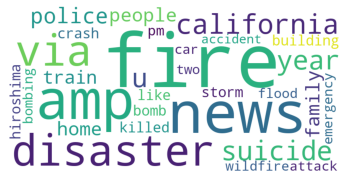

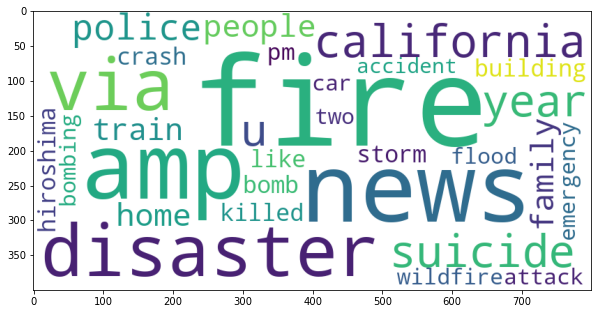

In [27]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white',width=800, height=400)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud)
#plt.show()


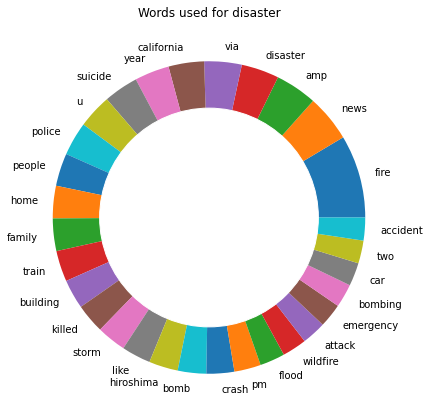

In [28]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(7,10))
my_circle=plt.Circle((0,0), 0.7, color='white')

plt.pie(disaster_common_words['count'], 
        labels=disaster_common_words.Word, startangle=-0) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Words used for disaster')
plt.show()


# model application

In [30]:
train_data = df.loc[pd.notnull(df.target)]

In [31]:
train_data.tail(3)

,id,keyword,location,text,target,url,emoji,text processed
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1.0,http://t.co/zDtoyd8EbJ,None,"[utc, km, volcano, hawaii]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1.0,None,None,"[police, investigating, e, bike, collided, car..."
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1.0,http://t.co/YmY4rSkQ3d,None,"[latest, home, razed, northern, california, wi..."


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text processed'])
X_data = tokenizer.texts_to_sequences(train_data['text processed']) 

In [33]:
#X_data

In [34]:
word_to_index = tokenizer.word_index

In [35]:
#word_to_index

In [36]:
len(word_to_index)

14831

In [37]:
max(len(i) for i in X_data)

25

In [38]:
vocab_size = len(word_to_index) + 1

In [39]:
max_len = max(len(i) for i in X_data)

# padding

In [40]:
X_data = pad_sequences(X_data, maxlen = max_len)

In [41]:
X_data.shape

(7613, 25)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, train_data.target,
                                                    test_size=0.2, 
                                                    random_state=0)
 

In [43]:
np.array(X_train).shape, np.array(y_train).shape

((6090, 25), (6090,))

In [208]:
model = Sequential()
model.add(Embedding(vocab_size, 40)) 
model.add(SimpleRNN(4)) # RNN layers 
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adagrad', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [209]:
history = model.fit(X_train, np.array(y_train), 
                    epochs=11, 
                    batch_size=1000, 
                    validation_split=0.2)

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/11
4872/4872 [==============================] - 1s 275us/step - loss: 0.6662 - accuracy: 0.6020 - val_loss: 0.6331 - val_accuracy: 0.6790
Epoch 2/11
4872/4872 [==============================] - 0s 47us/step - loss: 0.5316 - accuracy: 0.8931 - val_loss: 0.6056 - val_accuracy: 0.7258
Epoch 3/11
4872/4872 [==============================] - 0s 45us/step - loss: 0.4527 - accuracy: 0.9485 - val_loss: 0.5884 - val_accuracy: 0.7545
Epoch 4/11
4872/4872 [==============================] - 0s 45us/step - loss: 0.4090 - accuracy: 0.9575 - val_loss: 0.5814 - val_accuracy: 0.7455
Epoch 5/11
4872/4872 [==============================] - 0s 45us/step - loss: 0.3716 - accuracy: 0.9690 - val_loss: 0.5754 - val_accuracy: 0.7479
Epoch 6/11
4872/4872 [==============================] - 0s 46us/step - loss: 0.3439 - accuracy: 0.9756 - val_loss: 0.5680 - val_accuracy: 0.7406
Epoch 7/11
4872/4872 [==============================] - 0s 45us/step - loss: 0.32

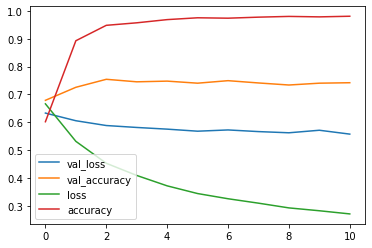

In [210]:
for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

In [197]:
model.evaluate(X_test, np.array(y_test))

1523/1523 [==============================] - 0s 127us/step


[0.5071274524093535, 0.7682206034660339]

In [198]:
test_pred = model.predict(X_test)

In [199]:
test_pred

array([[0.21020037],
       [0.2625888 ],
       [0.41013193],
       ...,
       [0.35164112],
       [0.09231162],
       [0.7875657 ]], dtype=float32)

In [200]:
test_pred_target = test_pred.argmax(axis=-1)

In [201]:
test_pred_target

array([0, 0, 0, ..., 0, 0, 0])

In [202]:
y_test[:3]

311     0.0
4970    0.0
527     0.0
Name: target, dtype: float64

In [203]:
df.text[1]

'Forest fire near La Ronge Sask. Canada'

In [204]:
X_test[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0, 11952, 11953,    10,   150,   412,  5550,   240,
          11,   539,   529,  1024,   170, 11954,  5491], dtype=int32)

In [205]:
for pred, true, i, x  in zip(np.squeeze(test_pred_target), y_test, y_test.index, df['text processed'].index):
    if pred!= true:
        print(df.text[i])
        print("Text used: ", df['text processed'][i])
        print('Pred: {:.0f} - True: {:.0f}'.format(pred,true) , '\n')

Fire destroys two buildings on 2nd Street in #Manchester 
Text used:  ['fire', 'destroys', 'two', 'building', 'nd', 'street', 'manchester']
Pred: 0 - True: 1 

Coming later this year~ 'THE MAN THAT TATTOOED WOMEN.' A novel based on a real serial killer from #Arkansas &amp; a natural disaster. #NOLA
Text used:  ['coming', 'later', 'year', 'man', 'tattooed', 'woman', 'novel', 'based', 'real', 'serial', 'killer', 'arkansas', 'amp', 'natural', 'disaster', 'nola']
Pred: 0 - True: 1 

CHICAGO (AP) ÛÓ Organizers of Lollapalooza say they are reopening the music festival after the threat of a storm prompted them to evacuate
Text used:  ['chicago', 'ap', 'organizer', 'lollapalooza', 'say', 'reopening', 'music', 'festival', 'threat', 'storm', 'prompted', 'evacuate']
Pred: 0 - True: 1 

Russian nuclear-biological-chemical (NBC) brigade 'emergency response' exercise in Southern MD  
Text used:  ['russian', 'nuclear', 'biological', 'chemical', 'nbc', 'brigade', 'emergency', 'response', 'exercise', 

#HungerArticles: Nepal: Rebuilding Lives and Livelihoods After Quake Devastation 
Text used:  ['hungerarticles', 'nepal', 'rebuilding', 'life', 'livelihood', 'quake', 'devastation']
Pred: 0 - True: 1 

Flooding kills 166 displace over one million in Pakistan - Daily News &amp; Analysis  #yugvani
Text used:  ['flooding', 'kill', 'displace', 'one', 'million', 'pakistan', 'daily', 'news', 'amp', 'analysis', 'yugvani']
Pred: 0 - True: 1 

Annihilated Abs . ?? 
Text used:  ['annihilated', 'ab']
Pred: 0 - True: 1 

@TomcatArts thus explaining why you were all annihilated. But the few or in this case you the only survivor evolved and became godlike
Text used:  ['tomcatarts', 'thus', 'explaining', 'annihilated', 'case', 'survivor', 'evolved', 'became', 'godlike']
Pred: 0 - True: 1 

70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... 
Text used:  ['year', 'atomic', 'bomb', 'japan', 'still', 'struggle', 'war', 'past', 'anniversary', '

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df.text.loc[pd.notnull(df.target)].tolist()
list_labels = df.target.loc[pd.notnull(df.target)].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=0)
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)